In [2]:
import torch
import torch.nn as nn
from evals import *
from optimization import *
from gauss_update import *
from kinetic_model import *
import cubic_spline_planner

In [3]:
import matplotlib.pyplot as plt
import numpy as np

ax = [0.0, 6.0, 12.5, 10.0, 7.5, 3.0, -1.0]
ay = [0.0, -3.0, -5.0, 6.5, 3.0, 5.0, -2.0]
goal = [ax[-1], ay[-1]]

cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.2)

plt.scatter(cx,cy)
plt.scatter(ax,ay,c='r')




In [4]:
class deviation_error_(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx,states,vs,waypoints,start):
        states = states.data.clone()
        states.requires_grad = True
        
        _range = torch.arange(len(states)).view(-1,1)
        range_ = _range.t()
        mask = (_range<=range_).float()
        
        inds = (mask.t()@vs.view(-1,1)).view(-1).round().long()+start
        #print(inds)
        #print([vs[:i+1].sum().data+start for i in range(len(vs))])
        dw = waypoints[inds+1]-waypoints[inds]
        
        refs = waypoints[inds].data.clone().requires_grad_()
        with torch.enable_grad():
            error = error_deviation_parallel_(states,refs,inds,ql,qc)
            de_s,de_w = torch.autograd.grad(error,[states]+[refs],grad_outputs=None,retain_graph=False,create_graph=False)
 
        ctx.save_for_backward(states.data.clone(),vs.data.clone(),waypoints,de_s.data.clone(),de_w.data.clone(),dw.data.clone())
        
        return error.data.clone()
    
    @staticmethod
    def backward(ctx,de):
        states,vs,waypoints,de_s,de_w,dw = ctx.saved_tensors
         
        de_theta = (de_w@dw.t()).diag().view(-1,1)
        _range = torch.arange(len(states)).view(-1,1)
        range_ = _range.t()
        mask = (_range<=range_).float()cx = torch.Tensor(cx).view(-1,1)
cy = torch.Tensor(cy).view(-1,1)

gx = cx[1:]-cx[:-1]
gy = cy[1:]-cy[:-1]


waypoints = torch.cat([cx[:-1],cy[:-1],gx,gy],dim=1)

start=150

x0,y0,gx0,gy0 = waypoints[start]
v0 = torch.sqrt(gx0.pow(2)+gy0.pow(2))*3
yaw0 = torch.atan2(gy0,gx0)
delta0=torch.zeros(1)
a0=torch.zeros(1)
state0 = torch.cat(  [x0.view(1),y0.view(1),yaw0.view(1),v0.view(1),delta0,a0])
control0 = torch.Tensor([0.0001,0.0001,0.001])
        
        de_v = (mask@de_theta).view(-1)
        #print(de_v)
        return de_s.data.clone(),de_v.data.clone(),None,None

In [109]:
cx = torch.Tensor(cx).view(-1,1)
cy = torch.Tensor(cy).view(-1,1)

gx = cx[1:]-cx[:-1]
gy = cy[1:]-cy[:-1]


waypoints = torch.cat([cx[:-1],cy[:-1],gx,gy],dim=1)

start=150

x0,y0,gx0,gy0 = waypoints[start]
v0 = torch.sqrt(gx0.pow(2)+gy0.pow(2))*3
yaw0 = torch.atan2(gy0,gx0)
delta0=torch.zeros(1)
a0=torch.zeros(1)
state0 = torch.cat(  [x0.view(1),y0.view(1),yaw0.view(1),v0.view(1),delta0,a0])
control0 = torch.Tensor([0.0001,0.0001,0.001])
state0

tensor([7.1618, 2.9268, 3.1397, 0.5057, 0.0000, 0.0000])

In [117]:
state0[3]=0.2

tensor([3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001,
        3.0001])
0.7396644 -0.30000994
0.13342646 -0.30000994
0.08984161 -0.30000994
0.07481848 -0.30000994
0.0706311 -0.30000994
0.06259345 -0.30000994
0.051519826 -0.30000994
0.046565443 -0.30000994
0.04194828 -0.30000994
0.038141076 -0.30000994
0.034598093 -0.30000994
0.031222954 -0.30000994
0.02798053 -0.30000994
0.024869721 -0.30000994
0.021899631 -0.30000994
0.019091371 -0.30000994
0.016481498 -0.30000994
0.014122797 -0.30000994
0.012078099 -0.30000994
0.010403979 -0.30000994


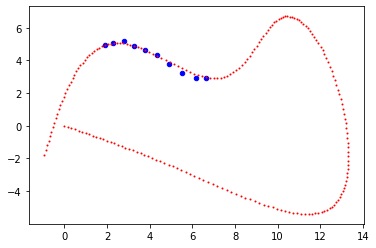

In [110]:
#初回

len_horizon = 10
EMAX=2000
kappa=0.01
TMAX = 1
_controls = torch.nn.Parameter(torch.zeros(len_horizon,2))

dt = torch.ones(len_horizon,1)
vs = torch.nn.Parameter(torch.ones(len_horizon)).data.clone()*3.0001


print(vs)
opt = torch.optim.Adam([vs]+[_controls],lr=0.01)
#print(controls.size())
for T in range(TMAX):
    if T>0:
        state0 = s2_[0]
        _controls = torch.nn.Parameter(controls2_.data.clone())
        start = start2_
    for epoch in range(EMAX):
        controls = torch.cat([_controls,dt],dim=1)
        s=state0
        s_=[]
        for t in range(len_horizon):
            s = model(s,controls[t])
            s_.append(s.view(1,-1))
        s_ = torch.cat(s_,dim=0)
        if epoch==0:
            s0_ = s_.data.clone()
        dev = deviation_error_.apply
        dev_loss = dev(s_,vs,waypoints,start)
        v_loss = -kappa*vs.sum()
        loss = dev_loss + v_loss
        if epoch % 100 ==0:
            print(dev_loss.data.numpy(),v_loss.data.numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
x_ = s_[:,0].data.numpy()
y_ = s_[:,1].data.numpy()
    
plt.scatter(x_,y_,c='b',s=20)
plt.scatter(cx,cy,c='r',s=1)
    

In [108]:
len_horizon = 10
EMAX=2000
kappa=0.01
TMAX = 1
_controls = torch.nn.Parameter(torch.zeros(len_horizon,2))



dt = torch.ones(len_horizon,1)
vs = torch.nn.Parameter(torch.ones(len_horizon)).data.clone()*3.0001

state0 = s2_[0]
_controls = torch.nn.Parameter(controls2_.data.clone())
start = start2_
print(state0)
print(_controls)

print(vs)
opt = torch.optim.Adam([vs]+[_controls],lr=0.01)
#print(controls.size())
print(start)
for T in range(TMAX):
    for epoch in range(EMAX):
        controls = torch.cat([_controls,dt],dim=1)
        s=state0
        s_=[]
        for t in range(len_horizon):
            s = model(s,controls[t])
            s_.append(s.view(1,-1))
        s_ = torch.cat(s_,dim=0)
        if epoch==0:
            s0_ = s_.data.clone()
        dev = deviation_error_.apply
        dev_loss = dev(s_,vs,waypoints,start)
        v_loss = -kappa*vs.sum()
        loss = dev_loss + v_loss
        if epoch % 100 ==0:
            print(dev_loss.data.numpy(),v_loss.data.numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
x_ = s_[:,0].data.numpy()
y_ = s_[:,1].data.numpy()
    
plt.scatter(x_,y_,c='b',s=20)
plt.scatter(cx,cy,c='r',s=1)
    

tensor([ 4.9153,  3.8062,  2.4008,  0.7471,  0.6306, -0.0991],
       grad_fn=<SelectBackward>)
Parameter containing:
tensor([[ 0.0423, -0.1589],
        [ 0.0579, -0.8063],
        [-1.0263, -1.1404],
        [ 1.0257,  1.1381],
        [-0.0241, -0.7162],
        [-0.0181,  0.1500],
        [-0.0085,  0.1448],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], requires_grad=True)
tensor([3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001,
        3.0001])
162
0.0006184621 -0.30000994
0.00079016766 -0.30000994
0.00062702526 -0.30000994
0.0005359805 -0.30000994


KeyboardInterrupt: 

In [94]:
vs,s_

(tensor([3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001, 3.0001,
         3.0001]),
 tensor([[ 5.5189,  3.2250,  2.3331,  0.5060, -0.1303, -0.3030],
         [ 5.1695,  3.5910,  2.3066,  0.2031,  0.8414,  0.4011],
         [ 5.0332,  3.7415,  2.3975,  0.6042,  0.7358,  0.1132],
         [ 4.5886,  4.1508,  2.6163,  0.7174, -0.1112, -0.0818],
         [ 3.9679,  4.5106,  2.5843,  0.6356, -2.3420, -0.1057],
         [ 3.4285,  4.8468,  2.8458,  0.5299,  0.5118, -0.0430],
         [ 2.9216,  5.0012,  2.9649,  0.4869,  1.1201, -0.0479],
         [ 2.4423,  5.0868,  3.3673,  0.4390,  0.9907,  0.0083],
         [ 2.0145,  4.9886,  3.6352,  0.4473,  0.9907,  0.0083],
         [ 1.6206,  4.7767,  3.9082,  0.4556,  0.9907,  0.0083]],
        grad_fn=<CatBackward>))

In [35]:
s0_

tensor([[ 4.9010,  3.9226,  2.4992,  0.7205,  0.6883,  0.3641],
        [ 4.3241,  4.3543,  2.7363,  1.0846,  0.6883,  0.3641],
        [ 3.3274,  4.7819,  3.0931,  1.4486,  0.6883,  0.3641],
        [ 1.8805,  4.8522,  3.5697,  1.8127,  0.6883,  0.3641],
        [ 0.2314,  4.0997,  4.1661,  2.1768,  0.6883,  0.3641],
        [-0.8995,  2.2398,  4.8822,  2.5408,  0.6883,  0.3641],
        [-0.4700, -0.2645,  5.7182,  2.9049,  0.6883,  0.3641],
        [ 1.9835, -1.8198,  6.6739,  3.2690,  0.6883,  0.3641],
        [ 5.0060, -0.5748,  7.7494,  3.6331,  0.6883,  0.3641],
        [ 5.3852,  3.0385,  8.9447,  3.9971,  0.6883,  0.3641]])

(tensor([[ 0.0423, -0.1589],
         [ 0.0579, -0.8063],
         [-1.0263, -1.1404],
         [ 1.0257,  1.1381],
         [-0.0241, -0.7162],
         [-0.0181,  0.1500],
         [-0.0085,  0.1448],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]], grad_fn=<CopySlices>), Parameter containing:
 tensor([[-0.0084,  0.5544],
         [ 0.0423, -0.1589],
         [ 0.0579, -0.8063],
         [-1.0263, -1.1404],
         [ 1.0257,  1.1381],
         [-0.0241, -0.7162],
         [-0.0181,  0.1500],
         [-0.0085,  0.1448],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]], requires_grad=True))

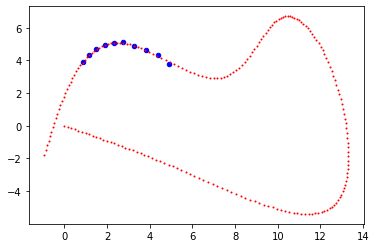

In [106]:
step = 0
s2_ = s_[step:]
x_ = s2_[:,0].data.numpy()
y_ = s2_[:,1].data.numpy()

controls2_ = _controls.data.clone()
controls2_[:-(step+1)] = _controls[step+1:]
controls2_[-(step+1):]=0
    
start2_ = start + (step +1)*3
plt.scatter(x_,y_,c='b',s=20)
plt.scatter(cx,cy,c='r',s=1)
controls2_,_controls


In [98]:
state0_ = s2_[0]
start_ = (start + vs[:3].sum().round().int())
controls_ = torch.cat( [_controls[2:],torch.zeros_like(_controls[:2])],dim=0)
#controls_[:,2]=1
controls_ = torch.nn.Parameter(controls_.data.clone())
vs_ = torch.zeros_like(vs)
vs_[:-2]=vs[2:]
vs_[-2:]=vs[-1]
vs_ = torch.nn.Parameter(vs_.data.clone())
vs_,controls_

(Parameter containing:
 tensor([1.8064, 2.2475, 2.6507, 2.8838, 3.0197, 3.0864, 3.1329, 3.1753, 3.1753,
         3.1753], requires_grad=True), Parameter containing:
 tensor([[-0.0636,  0.5025],
         [-0.0854,  0.4851],
         [-0.0546,  0.3112],
         [-0.0061,  0.1693],
         [ 0.0114,  0.0673],
         [-0.0148, -0.0405],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]], requires_grad=True))

In [94]:
state0_ = s2_[0]
start_ = (start + vs[:3].sum().round().int())
state0_

tensor([ 6.3231,  2.9579,  2.6732,  0.8252, -0.5831,  0.1357],
       grad_fn=<SelectBackward>)

tensor([ 6.3231,  2.9579,  2.6732,  0.8252, -0.5831,  0.1357],
       grad_fn=<SelectBackward>)
Parameter containing:
tensor([[-0.0636,  0.5025],
        [-0.0854,  0.4851],
        [-0.0546,  0.3112],
        [-0.0061,  0.1693],
        [ 0.0114,  0.0673],
        [-0.0148, -0.0405],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], requires_grad=True)
Parameter containing:
tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000], requires_grad=True)
6.667714 -0.80000013
1.916621 -0.87454194
1.2979115 -0.91283685
1.1404617 -0.9428396
0.96841985 -0.9706794
0.7207286 -0.99533665
0.6464384 -1.0122913
0.5910181 -1.0235221
0.56214887 -1.0318235
0.47636652 -1.0420655
0.4047236 -1.0545623
0.36866122 -1.0686553
0.32675186 -1.0746917
0.31590736 -1.0798696
0.28388274 -1.0842228
0.24586266 -1.0910887
0.22480865 -1.0989162
0.20326872 -1.1125824
0.16586623 -1.1272522
0.15343851 -1.134539
0.1588376

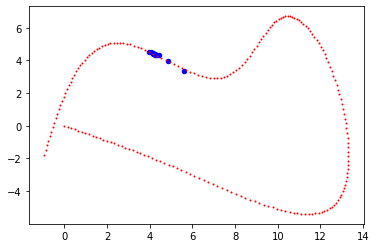

In [99]:
len_horizon = 10
EMAX=3000
kappa=0.1
TMAX = 1
#_controls = torch.nn.Parameter(torch.zeros(len_horizon,2))
print(state0_)
dt = torch.ones(len_horizon,1)
#controls_ = torch.nn.Parameter(torch.zeros(len_horizon,2))
dt = torch.ones(len_horizon,1)

vs_ = torch.nn.Parameter(torch.ones(len_horizon)*0.8)

print(controls_)

#vs = torch.nn.Parameter(torch.ones(len_horizon))
print(vs_)
opt = torch.optim.Adam([vs_]+[controls_],lr=0.001)
#print(controls.size())
for T in range(TMAX):
    for epoch in range(EMAX):
        controls = torch.cat([controls_,dt],dim=1)
        s=state0_
        s__=[]
        for t in range(len_horizon):
            #print(controls.size())
            s = model(s,controls[t])
            s__.append(s.view(1,-1))
        s__ = torch.cat(s__,dim=0)
        if epoch==0:
            s0_ = s__.data.clone()
        dev = deviation_error_.apply
        dev_loss = dev(s__,vs_,waypoints,start_)
        v_loss = -kappa*vs_.sum()
        loss =  dev_loss #v_loss + dev_loss 
        if epoch % 100 ==0:
            print(dev_loss.data.numpy(),v_loss.data.numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
x_ = s__[:,0].data.numpy()
y_ = s__[:,1].data.numpy()
    
plt.scatter(x_,y_,c='b',s=20)
plt.scatter(cx,cy,c='r',s=1)

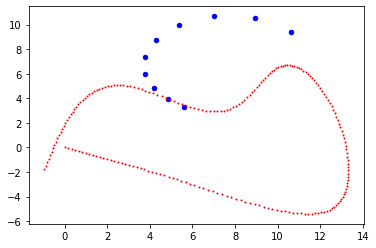

In [97]:
x_ = s0_[:,0].data.numpy()
y_ = s0_[:,1].data.numpy()
    
plt.scatter(x_,y_,c='b',s=20)
plt.scatter(cx,cy,c='r',s=1)

In [61]:
for i, s__ in enumerate(s_):
    print(search__(s__,[waypoints[:,0],waypoints[:,1],_,_],_indx=start_) ,vs[:i+1].sum()+start_)

tensor(153) tensor(153.8121, grad_fn=<AddBackward0>)
tensor(154) tensor(154.6242, grad_fn=<AddBackward0>)
tensor(155) tensor(155.5035, grad_fn=<AddBackward0>)
tensor(157) tensor(156.4247, grad_fn=<AddBackward0>)
tensor(158) tensor(157.3033, grad_fn=<AddBackward0>)
tensor(160) tensor(158.4999, grad_fn=<AddBackward0>)
tensor(162) tensor(159.8758, grad_fn=<AddBackward0>)
tensor(165) tensor(161.5962, grad_fn=<AddBackward0>)
tensor(168) tensor(163.5596, grad_fn=<AddBackward0>)
tensor(171) tensor(165.9267, grad_fn=<AddBackward0>)


In [53]:
def search__(state,waypoints,_indx):
    x,y = state[0],state[1]
    
    cx,cy,_,_ = waypoints
    dx = x-cx[_indx:_indx+L]
    dy = y-cy[_indx:_indx+L]
    d2 = dx.pow(2) + dy.pow(2)
    indx = torch.argmin(d2) + _indx

    return indx

In [ ]:
class mpc:
    def __init__(self,model,evals,optimizer,len_horizon,waypoints):
        self.model = model
        self.evals = evals
        self.optimizer = optimizer
        self.len_horizon = len_horizon
        self.waypoints = waypoints
        
    def 




In [ ]:
class grad_test(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx,x):
        ctx.save_for_backward(x)
        return x*x
    
    @staticmethod
    def backward(ctx,de):
        x = ctx.saved_tensors[0]
        print(x)
        return 2*x

In [ ]:
x=torch.Tensor([5.]).requires_grad_()
g = grad_test.apply
y = g(x)
print(y)
y.backward()
x.grad.data

In [ ]:
def error_deviation_parallel(states,waypoints,indices,ql,qc):
    x,y = states[:,0],states[:,1]
    cx,cy,gx,gy = waypoints[indices,0],waypoints[indices,1],waypoints[indices,2],waypoints[indices,3]
    el = -gx*(x-cx) - gy*(y-cy)
    ec =  gy*(x-cx) - gx*(y-cy)
    err = ql*el.pow(2).sum()+qc*ec.pow(2).sum()
    return err

In [ ]:
def error_deviation_parallel_(states,refs,indices,ql,qc):
    x,y = states[:,0],states[:,1]
    cx,cy,gx,gy = refs[:,0],refs[:,1],refs[:,2],refs[:,3]
    el = -gx*(x-cx) - gy*(y-cy)
    ec =  gy*(x-cx) - gx*(y-cy)
    err = ql*el.pow(2).sum()+qc*ec.pow(2).sum()
    return err

In [ ]:
import torch

ql=1
qc=1

class deviation_error(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx,states,vs,waypoints):
        states = states.data.clone()
        states.requires_grad = True
        
        inds = vs.round().long()
        
        dw = waypoints[inds+1]-waypoints[inds]
        
        refs = waypoints[inds].data.clone().requires_grad_()
        with torch.enable_grad():
            error = error_deviation_parallel_(states,refs,inds,ql,qc)
            de_s,de_w = torch.autograd.grad(error,[states]+[refs],grad_outputs=None,retain_graph=False,create_graph=False)
 
        ctx.save_for_backward(states.data.clone(),vs.data.clone(),waypoints,de_s.data.clone(),de_w.data.clone(),dw.data.clone())
        
        return error
    
    @staticmethod
    def backward(ctx,de):
        states,vs,waypoints,de_s,de_w,dw = ctx.saved_tensors
          
        de_theta = (de_w@dw.t()).diag().view(-1,1)
        
        _range = torch.arange(len(states)).view(-1,1)
        range_ = _range.t()
        mask = (_range<=range_).float()
        de_v = (mask@de_theta).view(-1)
   
        
        return de_s,de_v,None

In [87]:
state0,state0_

(tensor([7.1618, 2.9268, 3.1397, 0.1686, 0.0000, 0.0000]),
 tensor([ 6.3231,  2.9579,  2.6732,  0.8252, -0.5831,  0.1357],
        grad_fn=<SelectBackward>))

In [ ]:
import torch

ql=1
qc=1

class deviation_error(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx,states,vs,waypoints):
        states = states.data.clone()
        states.requires_grad = True
        
        inds = vs.round().long()
        
        dw = waypoints[inds+1]-waypoints[inds]
        print(states.size())
       
        with torch.enable_grad():
            error = error_deviation_parallel(states,waypoints,inds,ql,qc)
            de_s = torch.autograd.grad(error,states,grad_outputs=None,retain_graph=False,create_graph=False)[0]
        print(de_s.size(),states.size())
              
        de_w = -de_s
        ctx.save_for_backward(states.data.clone(),vs.data.clone(),waypoints,de_s.data.clone(),de_w.data.clone(),dw.data.clone())
        print(states,vs.size(),waypoints.size(),de_s.size(),de_w.size(),dw.size())
        
        return error
    
    @staticmethod
    def backward(ctx,de):
        states,vs,waypoints,de_s,de_w,dw = ctx.saved_tensors
        de_w = torch.zeros(len(vs),waypoints.size()[1])
        
        de_w[:,:2] = -de_s[:,:2]
        
        de_theta = (de_w@dw.t()).diag().view(-1,1)
        
        _range = torch.range(0,len(states)-1).view(-1,1)
        range_ = _range.t()
        mask = (_range<=range_).float()
        de_v = (mask@de_theta).view(-1)
        print("########")
        print(de_s)
        print("########")
        print(de_w)
        print("########")
        print(de_v)
        print("########")
        
        return de_s,de_v,None


In [ ]:
states=torch.ones(5,3).requires_grad_()
vs = torch.Tensor([1.1,2.1,3.3,4.7,10.7]).requires_grad_()


opt = torch.optim.Adam([states]+[vs],lr=0.1)

waypoints = (torch.range(0,100)+0.4).view(-1,1).repeat(1,4)
print( waypoints.size() )

de = deviation_error.apply
err = de(states,vs,waypoints)
print(err)
opt.zero_grad()
err.backward()
print(vs.grad.data,states.grad.data)

_range = torch.range(0,len(states)).view(-1,1)
range_ = _range.t()
mask = (_range<=range_).float()
mask

In [ ]:
torch.range(0,5).view(-1,1)

In [ ]:
import torch
import numpy as np
states = torch.nn.Parameter(torch.ones(10,3))
waypoints = torch.zeros(100,4)
v= torch.Tensor(np.arange(10)).float()
inds= v.round().long()

#print(v)
#print(v+1)
#inds = [*range(10)]

dw = waypoints[inds+1,:2]-waypoints[inds,:2]
print(dw)
error = error_deviation_parallel(states,waypoints,indices,ql=1,qc=1)


de_s = torch.autograd.grad(error,states,grad_outputs=None,retain_graph=False,create_graph=False)
de_s[0].size()

In [ ]:

loss = inds.sum()
opt=torch.optim.SGD([vs],lr=0.1)
opt.zero_grad()
print(vs.grad)
loss.backward()
print(vs.grad)

In [ ]:
waypoints[0]
hl=20

das = torch.nn.Parameter(torch.zeros(hl))
dds = torch.nn.Parameter(torch.zeros(hl))

controls = torch.nn.Parameter(torch.zeros(hl,3))
controls[:,2]+=0.01

vs = torch.nn.Parameter(torch.arange(1,hl).float()) 
inds = vs.round()
state = torch.Tensor([ 0,0,-0.48,0.01,0.0,0.01 ])

#_states=[state.view(1,-1)]
_states = []

for t in range(hl-1): 
    state = forward(state,controls[t])
    _states.append(state.view(1,-1))


states = torch.cat(_states,dim=0)

states.size(),vs.size()
inds

In [ ]:
def search_(state,waypoints,_indx):
    x,y,_,_,_,_ = state
    cx,cy = waypoints[:,0],waypoints[:,1]
    dx = x-cx[_indx:_indx+L]
    dy = y-cy[_indx:_indx+L]
    d2 = dx.pow(2) + dy.pow(2)
    indx = torch.argmin(d2) + _indx

    return indx

In [ ]:
states[16]

In [ ]:
search_parallel(states[:16],waypoints,0)

In [ ]:
L=100
def search_parallel(states,waypoints,_indx):
    xs,ys = states[:,0].view(-1,1),states[:,1].view(-1,1)
    cx,cy = waypoints[:,0].view(1,-1),waypoints[:,1].view(1,-1)
    dx = xs - cx[:,_indx:_indx+L]
    dy = ys - cy[:,_indx:_indx+L]
    d2 = dx.pow(2) + dy.pow(2)
    inds = torch.argmin(d2,dim=1) + _indx
    return inds

In [ ]:
state=torch.Tensor([1,1,1,1,1,1])
control=torch.Tensor([1,1,1])
forward(state,control)


In [ ]:
d=torch.ones(2)
torch.max(d,2*torch.ones_like(d))

In [ ]:
THRESHOLD = -0.01
learning_rate = 0.001
EMAX=100000

class constrained_optimization:
    def __init__(self,obj,cons,myu):
        self.obj = obj
        self.cons = cons
        self.myu = myu
    
    def compute_penalty(self,x):
        penalty = 0
        for con in self.cons:
            c = torch.max(con(x),THRESHOLD*torch.ones_like(con(x)))
            #if c>THRESHOLD:
            penalty += torch.log(-c).sum()
        return penalty
    
    def compute_cost(self,x):
        cost = self.obj(x) - self.myu*self.compute_penalty(x)
        return cost
    
    def judge_bleaching(self,x):
        judge = torch.prod(torch.cat([torch.prod(c(x)<=0).view(1) for c in self.cons]) )
        return judge

    def run(self,x0):
        c=0
        x = torch.nn.Parameter(x0)
        opt=torch.optim.Adam([x],lr=learning_rate)
        _x = x.data.clone()
        for epoch in range(EMAX):
       
            cost = self.compute_cost(x)
            opt.zero_grad()
            cost.backward()
            opt.step()
            
            if self.judge_bleaching(x):
                _x = x.data.clone()
            else:
                return _x
        return x

In [ ]:
def objective(x):
    return x.pow(2).sum()

In [ ]:
def const1(x):
    return x-5
def const2(x):
    return (x-1).pow(2).sum()-1

In [ ]:
co = constrained_optimization(objective,[const2],myu=0.0001)
x0 = torch.FloatTensor([1.2,1.2])
x=co.run(x0)

In [ ]:
#x=torch.Tensor([0,0])
(x-1).pow(2).sum()-1
(x-1.01).pow(2).sum()-1


In [ ]:
x-5

In [ ]:
m=1500
I=2500
lf=1.1
lr=1.6
Kf=55
Kr=60

In [ ]:
def forward(state,control):
    x,y,phi,vx,vy,r,delta,T = state
    d_delta,dt = control
    
    cos_p = torch.cos(phi)
    sin_p = torch.sin(phi)
    cos_d = torch.cos(delta)
    sin_d = torch.sin(delta)
    
    alpha_r = torch.atan((vy-lr*r)/vx )
    alpha_f = torch.atan((vy-lf*r)/vx - delta )
    
    Fry = Dr*torch.sin( Cr*torch.atan(B*alpha_r) )
    Fry = Df*torch.sin( Cf*torch.atan(B*alpha_f) )
    Fx = Cm2*T - Cr0 - Cr2*vx*vx #those parameters to be determin
    r_target = delta*vx/(lf+lr)
    tau = (r_target-r)*Ptv
    
    v_2 = vx.pow(2) + vy.pow(2)
    v = torch.(sqrt(v_2))
    
    d_beta = -r - 2*(Kf*(beta+lr/v*r-delta)+Kr*(beta-lr/v*r) )/m/v
    d_r = -2*( Kf*(beta+lf/v*r-delta)*lf + Kr*(beta-lr/V*r)*lr )/I
    
    dx = vx*cos_p - vy*sin_p
    dy = vx*sin_p + vy*cos_p
    d_phi = r
    dvx = (Fx - Ffy*sin_d + m*vy*r)/m
    dvy = (Fry - Ffy*cos_d - m*vx*r)/m
    dr = (Ffy*lf*cos_d - Fry*lr + tau)/lz
    
    x_     = x + dx*dt
    y_     = y + dy*dt
    phi_   = phi + d_phi*dt
    vx_    = vx + dvx*dt
    vy_    = vy + dvy*dt
    r_     = r + dr*dt
    delta_ = delta + d_delta
    T_     = T + dt
    

In [ ]:
a=np.zeros(10)
a.shape

In [ ]:
def construct_sigma(df,dg,sigma_x,sigma_w,B):
    
    sigma_00 = sigma_x
    sigma_10 = dg@sigma_x
    sigma_01 = sigma_10.t()
    sigma_11 = sigma_10@dg.t() + sigma_w
    
    sigma_0 = torch.cat([sigma_00,sigma_01],dim=1)
    sigma_1 = torch.cat([sigma_10,sigma_11],dim=1)
    
    sigma_ = torch.cat([sigma_0,sigma_1],dim=0)
    
    vec = torch.cat([df,B],dim=1)
    
    sigma = vec@sigma_@vec.t()
    
    return sigma

In [ ]:
def evaluate(func,state,control,grad=True):
    F = func(state,control)
    dF = None
    if grad:
        dF_ = [torch.autograd.grad(f,[state],grad_outputs=None,retain_graph=True,create_graph=False,only_inputs=True,allow_unused=True)[0].view(1,-1) for f in F]
        dF  = torch.cat(dF_,dim=0)
    return F,dF

In [ ]:
def process(state,control):
    s0 = state[0]*control[0]
    s1 = state[1]*control[1]
    s2 = state[2]*control[1]
    
    return torch.cat([s0.view(1),s1.view(1),s2.view(1)],dim=0)

In [ ]:
def error_model(state,control):
    e0 = state[0]*control[0]*0.1
    e1 = state[1]*control[1]*0.1
    return torch.cat([e0.view(1),e1.view(1)],dim=0)

In [ ]:
sigma_x = torch.eye(3)*2
sigma_w = torch.eye(2)*2
B = torch.cat([torch.eye(2),torch.zeros(1,2)],dim=0)
B

In [ ]:
state = torch.nn.Parameter(torch.Tensor([1.,2.,3.]))
print(state.requires_grad)
control = torch.Tensor([2.,1.])
f,df = evaluate(process,state,control)
g,dg = evaluate(error_model,state,control)
construct_sigma(df,dg,sigma_x,sigma_w,B)

In [ ]:
import cubic_spline_planner

In [ ]:
print("LQR steering control tracking start!!")
ax = [0.0, 6.0, 12.5, 10.0, 7.5, 3.0, -1.0]
ay = [0.0, -3.0, -5.0, 6.5, 3.0, 5.0, -2.0]
goal = [ax[-1], ay[-1]]

cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.0001)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print("LQR steering control tracking start!!")
ax = [0.0, 6.0, 12.5, 10.0, 7.5, 3.0, -1.0]
ay = [0.0, -3.0, -5.0, 6.5, 3.0, 5.0, -2.0]
goal = [ax[-1], ay[-1]]

cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.0001)
i=0000
dx = (cx[i+1]-2*cx[i]+cx[i-1])/2
dy = (cy[i+1]-2*cy[i]+cy[i-1])/2
print(dy/dx,cyaw[i])
plt.scatter(cx[i:],cy[i:])
plt.scatter(ax,ay,c='r')
gx=np.com
ir

In [ ]:
gy[0]/gx[0]

In [ ]:

import numpy as np

cx = np.array(cx)
cy = np.array(cy)

dx = cx[1:]-cx[:-1]
dy = cy[1:]-cy[:-1]

grad = dy/dx

gx,gy = np.cos(grad),np.sin(grad)

gx=np.append(gx,0)
gy=np.append(gy,0)


waypoints = torch.cat([torch.FloatTensor(cx).view(-1,1),torch.FloatTensor(cy).view(-1,1),torch.FloatTensor(gx).view(-1,1),torch.FloatTensor(gy).view(-1,1)] ,dim=1)
waypoints.size()

In [ ]:

dx = (cx[i+1]-2*cx[i]+cx[i-1])/2
dy = (cy[i+1]-2*cy[i]+cy[i-1])/2
print(dy/dx,cyaw[i])

In [ ]:
a=torch.zeros(10,4)
indices=[1,4,5]
a[indices,0]

In [ ]:
states = torch.ones(3,2)
indices = [10,20,30]
e = compute_error_parallel(states,waypoints,indices,1,2)
e,waypoints[indices]

In [ ]:
a=torch.Tensor([1.001])
a.round()

In [ ]:
def 



In [ ]:
def compute_error_parallel(states,waypoints,indices,ql,qc):
    x,y = states[:,0],states[:,1]
    cx,cy,gx,gy = waypoints[indices,0],waypoints[indices,1],waypoints[indices,2],waypoints[indices,3]
    el = -gx*(x-cx) - gy*(y-cy)
    ec =  gy*(x-cx) - gx*(y-cy)
    err = ql*el.pow(2).sum()+qc*ec.pow(2).sum()
    return err

In [ ]:
def compute_error(state,waypoints,indx):
    x,y,phi,vx,vy,r,delta,T = state
    cx,cy,gx,gy = waypoints[indx]   
    el = -gx*(x-cx) - gy*(y-cy)
    ec =  gy*(x-cx) - gx*(y-cy)
    return el,ec

In [ ]:
L = 100

def search_(state,waypoints,_indx):
    x,y,phi,vx,vy,r,delta,T = state
    cx,cy,gx,gy = waypoints
    dx = x-cx[_indx:_indx+L]
    dy = y-cy[_indx:_indx+L]
    d2 = dx.pow(2) + dy.pow(2)
    indx = torch.argmin(d2) + _indx

    return indx_


In [ ]:
import torch

waypoints = torch.Tensor(cx),torch.Tensor(cy),_,_
states = torch.Tensor([0.00081]),torch.Tensor([-0.00041]),_,_,_,_,_,_
ind = 7
ind_ = compute_error(states,waypoints,ind)


In [ ]:
ind_

In [ ]:
waypoints[0][10],waypoints[1][10]